### Motivación
Resulta que hasta el momento nuestro flujo de trabajo conlleva evaluar múltiples modelos y
posteriormente escoger el que tenga un mejor desempeño en los datos. Si bien este
enfoque es intuitivo para nosotros, hay un par de contratiempos asociados:
- Cuando implementamos un modelo en los datos, estamos ignorando
  deliberadamente todos los demás modelos candidatos que no son "lo
  uficientemente buenos". Estos clasificadores se conocen como clasificadores
  débiles (weak learners, Kearns y Valliant, 1989), que se desempeñan marginalmente
  mejor que un clasificador aleatorio con chance 1/𝑁𝑦 Kearns y Valliant (1989) se
  preguntaron sobre qué tan válidos son los clasificadores débiles, y qué hacer frente a
  ellos.
- Cuando elegimos un modelo dentro de una serie de candidatos, inevitablemente
  favorece a un modelo con mayor sesgo o varianza. Este punto es extremadamente
  relevante en los árboles de decisión, donde se estima de forma local en los datos de
  entrenamiento.

Ante estas limitantes, el enfoque es agrupar modelos en lo que se conocen como
ensambles. La intuición detrás de los ensambles es entrenar múltiples modelos de
aprendizaje para resolver el mismo problema. Mediante la agrupación de múltiples
clasificadores débiles potenciamos la capacidad de generalización, permitiendo que entre
cada modelo exista colaboración y se potencien en su capacidad predictiva (Zhou, 2012).
Existen dos grandes modos de ensamblar modelos: paralelos y secuenciales. En esta
lectura abordaremos los ensambles paralelos, específicamente Bagging y Random Forest.

### Bagging: Booststrap Aggregation
Consideremos una de las falencias principales de los árboles de decisión: dado que se
optimizan de forma local en los datos de entrenamiento, pueden sufrir de alta varianza,
disminuyendo su capacidad de generalización a datos previamente no vistos. Ya
conocemos algunas estrategias dentro del modelo para aliviar este problema, como definir
los criterios de partición, profundidad máxima de los nodos y cantidad de atributos a
considerar en el modelo.

Leo Breiman (1984) sugirió otra alternativa: entrenar múltiples árboles de decisión con
distintas muestras seleccionadas de forma aleatoria con reemplazo. Esta estrategia de
aleatorizar se conoce como bootstraping. Es necesaria una pequeña digresión sobre ésta
técnica:

### Digresión: Bootstrap
Un problema clásico de la inferencia estadística es el hecho que muchos de sus métodos se
apoyan en características asintóticas que guían hacia distribuciones normales y chi
cuadrado.

Una alternativa se proporciona mediante el bootstrap, que busca aproximar la distribución
de un estadístico mediante simulación Monte Carlo con el muestreo realizado a partir de la
distribución empírica o estimada de los datos observados. Este muestreo corresponde a un
muestreo con reemplazo.

La idea base del Bootstrap es generar inferencia de una población a partir de una muestra,
que se puede obtener mediante el remuestreo de la muestra.

#### Algorítmo básico de bootstrap
1. Dado datos $X_1 \in X$ extraer N datos implementando un método definido y guardar los
   datos en una nueva muestra $𝑥_1^° \in X^°$

2. Generar un estimado adecuado utilizando esta nueva muestra.
3. Repetir B veces los pasos 1 y 2, donde B es un número grande. Con esto podremos
   obtener B replicaciones del estimando de interés $\hat 0 \in \hat 0$
4. Finalizada la iteración en B estimar el nuevo estimador con:
   - Estimador puntual de la media:

   $$ \hat\theta^{-*} = \dfrac{1}{B-1} \sum^B_{b=1}(\hat\theta^*_b - \hat\theta^{-*}_b)^2$$

   - Estimador puntual de la varianza:

   $$s^{2}_{\hat\theta}Bootstrap = \dfrac{1}{B-1} \sum^B_{b=1}(\hat\theta^*_b - \hat\theta^{-*}_b)^2$$

Para ejemplificar su comportamiento, generaremos una simulación donde generamos un
remuestreo de los datos disponibles. En la figura afx.plot_bootstrap comparamos la
distribución teórica de una variable $𝑋_𝑝𝑜𝑝$ ∼ 𝑁𝑜𝑟𝑚𝑎𝑙(0, 1) con el comportamiento realizado en
la cantidad de remuestreos. En la práctica, si tenemos la información poblacional, el
bootstrapping no sería necesario.

Al generar distintas instancias sobre esta distribución teórica, somos capaces de imitar su
comportamiento, lo que nos permite asimilar características en la medida que
re-muestremos todo el espacio de los datos.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor

import lec8_graphs as afx

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

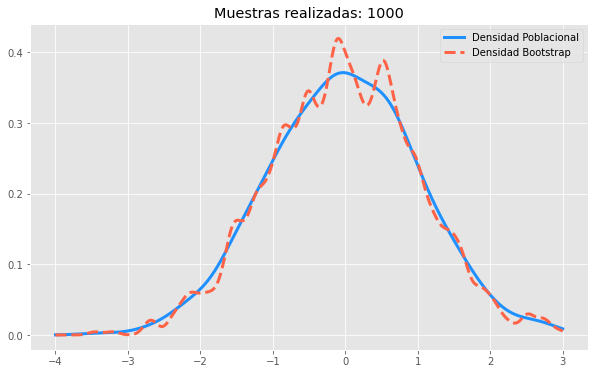

In [2]:
afx.plot_bootstrap(n_sims = 1000)

#### Idea base de Bagging
El principal problema de un árbol es el hecho que puede sufrir de alta varianza en los datos
de entrenamiento. Si bien técnicas como pruning puede reducir la varianza al eliminar nodos
innecesarios, hay métodos alternativos que se benefician del overfit producto de los árboles.
Bagging combina y promedia múltiples modelos. Mediante la ponderación de múltiples
árboles se contrarresta la variabilidad de cualquier árbol y reduce el overfit, mejorando su
capacidad predictiva.

![bootstrap](fotos/bootstrap.jpg)

1. Crear M muestras mediante bootstrap de la muestra de entrenamiento. Con este
   proceso, generamos distintos subconjuntos de datos que compartirán una
   distribución similar a la muestra de entrenamiento.
2. Dentro de cada muestra 𝑚 ∈ 𝑀 se entrena un árbol donde sus nodos crecen al
   máximo.
3. Para una observación previamente no observada, se promedian las predicciones de
   cada árbol para crear un valor promedio global.

Cabe destacar que este procedimiento es agnóstico a la implementación. Podríamos
implementarlo en modelos de regresión y sus variantes, pero resulta que su mejor
desempeño es cuando incorporamos datos donde los modelos sufren de alta varianza.
Resulta que Bagging es una estrategia generalizable a múltiples modelos, orientada a la
reducción de la varianza mediante la repetición del entrenamiento en múltiples muestras. Si
bien se puede aplicar en contextos como regresiones, es en los árboles donde tiene un
mejor desempeño dado que estabiliza la predicción en múltiples instancias.

Si tomamos un clasificador binario débil que busca asignar clases en el vector objetivo
γ = {− 1, 1} y entrenamos un modelo representado con $ℎ_t(x)$ éste tendrá un error de
generalización en nuevas observaciones de ε𝑦.

El error de generalización en el modelo específico será la probabilidad de no ocurrencia en
otro modelo 𝑃𝑟(ℎ𝑡(𝑥) ≠ 𝑓(𝑥)).
Mediante Bagging podemos sumar y promediar cada uno de los clasificadores binarios
débiles con:

$$H(X) = sign(\sum^{T}_{t=1} h_t(X))$$

Donde T es la cantidad de modelos entrenados. Para cada una de las observaciones en la
muestra de entrenamiento, sumamos la clase predicha en cada modelo. El ensamble 𝐻
generará un error sólo cuando la mitad o más de los clasificadores débiles 𝑡 ∈ 𝑇 generen un
error.

Otra de las ventajas de implementar bootstraping en el proceso de Bagging es atenuar la
dependencia entre clasificadores débiles. Dado que todos son generados en base a la
misma muestra de entrenamiento, el modelo estará aprendiendo estos datos en una tasa
muy rápida. Mediante bootstrap generamos muestras donde ignoraremos ciertas
observaciones, induciendo aleatoriedad en el proceso de entrenamiento del modelo.

Uno de los beneficios de bagging es que en promedio una muestra creada con bootstrap
contendrá un .63 de la muestra de entrenamiento. Esto nos deja con un .33 de los datos que
se encontrarán fuera de la muestra. Esta cifra se conoce como el out-of-bag-sample para
estimar el error en la muestra de validación. Este punto confiere una característica deseable
de Bagging: En la medida que aumentamos la cantidad de muestras generadas con
bootstrap, podemos implementar la out-of-bag-sample para estimar la exactitud del modelo
en sus predicciones, conllevando a un proceso similar a la validación cruzada.
Re-visitaremos esta idea cuando posteriormente en esta lectura con los Random Forest.

#### Implementando Bagging para los Precios de California
Para ejemplificar el uso de Bagging, utilizaremos la base de datos sobre los precios de
inmuebles en California utilizada en el ejemplo de Árboles de Decisión. Esto nos permitirá
realizar comparaciones respecto al comportamiento de ambos modelos. Partamos por
implementar el mismo preprocesamiento de datos.


In [3]:
df = pd.read_csv('Datasets/cadata.csv', header = 1).drop(columns = '1')
df.sample(5, random_state = 15820)

,MedianHouseValue,MedianIncome,MedianHouseAge,TotalRooms,TotalBedrooms,Population,Households,Latitude,Longitude
6637,153500.0,2.5750,39.0,2776.0,840.0,2546.0,773.0,34.16,-118.14
9831,313900.0,3.5147,28.0,3983.0,852.0,1582.0,778.0,36.63,-121.93
5992,154200.0,4.2639,26.0,2744.0,494.0,1411.0,465.0,34.08,-117.71
7477,121000.0,2.6953,36.0,1337.0,382.0,1769.0,393.0,33.93,-118.21
4494,109100.0,2.0950,52.0,470.0,115.0,434.0,123.0,34.06,-118.21


In [4]:
df['log_MedianIncome'] = np.log(df['MedianIncome'])
df['log_MedianHouseValue'] = np.log(df['MedianHouseValue'])
df = df.drop(columns=['MedianHouseValue', 'MedianIncome'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'MedianHouseAge':'log_MedianIncome'], 
                                                    df['log_MedianHouseValue'], test_size = .33, random_state = 15820)

Para implementar Bagging con árboles de regresión, debemos incorporar la clase
sklearn.ensemble.BaggingRegressor. Dado que en esta implementación utilizaremos
árboles de regresión que vienen por defecto implementados en la clase, no es necesario
especificar sobre el comportamiento de hiper parámetros todavía, con la salvedad de
implementar una semilla, para asegurar la replicación de resultados.

#### Digresión:
#### sklearn.ensemble.BaggingRegressor/BaggingClassifier

La API es generalizable, por defecto implementa árboles pero se puede incorporar cualquier
modelo que forme parte de scikit-learn. Resulta que la implementación se realiza en
consideración al efecto reductor de varianza, haciéndolo un procedimiento fuertemente
asociado con los árboles de decisión.
Si implementamos nuestro modelo sin modificar hiperparámetros, la clase
BaggingRegressor generará 10 modelos. Como todo modelo de scikit-learn, para
entrenarlo necesitamos utilizar el método fit.


In [6]:
bagging_model = BaggingRegressor(random_state = 15820).fit(X_train,y_train)

Comencemos por examinar cada uno de los árboles. Éstos se encuentran dentro del modelo
en BaggingRegressor.estimators_. Vamos a solicitar la información sobre el tipo de
modelo, el criterio y la semilla pseudoaleatoria asociada a cada uno de ellos. Observamos
que por defecto implementa modelos sklearn.tree.tree.DecisionTreeRegressor, con
el criterio de optimización 'mse' y una semilla que varía entre cada uno de ellos.

In [7]:
for i in bagging_model.estimators_:
    print(f'Modelo: {type(i)}. Criterio: {i.criterion}. Semilla: {i.random_state}.')

Modelo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>. Criterio: squared_error. Semilla: 132547776.
Modelo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>. Criterio: squared_error. Semilla: 1779331324.
Modelo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>. Criterio: squared_error. Semilla: 980340428.
Modelo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>. Criterio: squared_error. Semilla: 714888096.
Modelo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>. Criterio: squared_error. Semilla: 510756111.
Modelo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>. Criterio: squared_error. Semilla: 907522183.
Modelo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>. Criterio: squared_error. Semilla: 2116648559.
Modelo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>. Criterio: squared_error. Semilla: 2093998503.
Modelo: <class 'sklearn.tree._classes.DecisionTreeRegressor'>. Criterio: squared_error. Semilla: 940875024.
Modelo: <class 'sklearn.t

Ahora evaluemos el desempeño del ensamble Bagging con las métricas
mean_squared_error y r2_score. Para ello tomemos en cuenta que el desempeño del
árbol de decisión que implementamos en la lectura anterior era el siguiente:

![tabla](fotos/table.jpg)

Observamos que simplemente con 10 árboles promediados, nuestro error cuadrático
promedio disminuyó en 0.049, la mediana absoluta del error disminuyó en 0.034 y el
coeficiente de determinación aumento en .147.


In [8]:
print(f'''Metricas de desempeño.

MSE: {mean_squared_error(y_test, bagging_model.predict(X_test))}
MAE: {median_absolute_error(y_test, bagging_model.predict(X_test))}
R2 Score: { r2_score(y_test, bagging_model.predict(X_test))}''')

Metricas de desempeño.

MSE: 0.05767002694294763
MAE: 0.12178450775615524
R2 Score: 0.8183466223117482


Inspeccionando las predicciones
Ya sabemos cómo se comporta la clase sklearn.ensemble.BaggingRegressor a grandes
rasgos. Ahora ejemplificamos cómo se genera el proceso de predicción para una
observación específica en el testing set.
La observación que tenemos corresponde a las siguientes características:

In [9]:
X_test[:1]

,MedianHouseAge,TotalRooms,TotalBedrooms,Population,Households,Latitude,Longitude,log_MedianIncome
6637,39.0,2776.0,840.0,2546.0,773.0,34.16,-118.14,0.94585


Su valor verdadero en el vector objetivo es de:

In [10]:
y_test[:1]

6637    11.941456
Name: log_MedianHouseValue, dtype: float64

Lo que necesitamos hacer es generar una predicción de esta observación en cada árbol de
regresión entrenado en nuestro ensamble de Bagging. Para ello implementaremos la
siguiente comprensión de lista:

In [11]:
hold_instance = [i.predict(X_test[:1]) for i in bagging_model.estimators_]

Para facilitar el proceso de visualización, generamos un eje X con las etiquetas pertinentes a
cada árbol.

In [12]:
dec_tree_lab = ["RegressionTree: {}".format(i + 1) for i in range(len(bagging_model.estimators_))]

Cada punto azul en la figura creada corresponde a la predicción realizada por un árbol en
específico. La recta roja representa la predicción promediada del ensamble con Bagging. La
predicción del modelo toma en consideración cada uno de los puntos específicos.

Retomemos nuestros conocimientos básicos de estadística. Resulta que en la medida que
nuestro ensamble de Bagging aumenta la cantidad de estimadores entrenados, estaremos
recabando más información sobre el parámetro poblacional a inferir. Esta es una aplicación
de la ley de los grandes números.

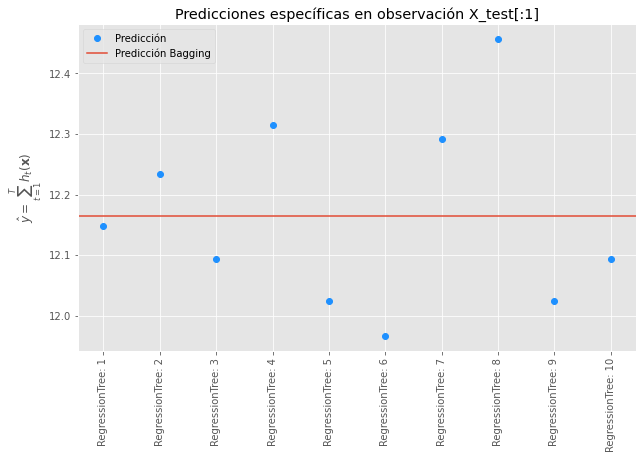

In [13]:
plt.plot(hold_instance, 'o', color = 'dodgerblue', label = 'Predicción')
plt.xticks(range(10), dec_tree_lab,rotation = 90)
plt.axhline(bagging_model.predict(X_test[:1]), label = 'Predicción Bagging')
plt.ylabel(r'$\hat{y} = \sum_{t=1}^{T} h_{t}(\mathbf{x})$')
plt.title('Predicciones específicas en observación X_test[:1]')
plt.legend()

#### Efecto de la cantidad de modelos incorporados en el ensamble

Sigamos expandiendo la idea del comportamiento asintótico de los ensambles. Resulta que
este comportamiento también es válido cuando nos referimos al desempeño general del
modelo. Consideremos el siguiente experimento: Vamos a entrenar 40 modelos con nuestro
regresor Bagging, donde incrementaremos en pasos de 25 la cantidad de estimadores
incluídos, hasta llegar a aproximadamente 1000

In [14]:
# generamos 3 listas para guardar resultados
# generamos valores a pasar
# Para cada uno de los rangos declarados
tmp_mse_test, tmp_mae_test, tmp_r2_test = [], [], []
n_tree = range(20, 1000, 50)

for i in n_tree:
    # Entrenamos nuestro modelo
    # guardamos el mse
    # guardamos el mae
    # guardamos el rcuadrado
    tmp_bag_model = BaggingRegressor(n_estimators = i, random_state = 15820).fit(X_train,y_train)
    tmp_mse_test.append(mean_squared_error(y_test, tmp_bag_model.predict(X_test)))
    tmp_mae_test.append(median_absolute_error(y_test, tmp_bag_model.predict(X_test)))
    tmp_r2_test.append(r2_score(y_test, tmp_bag_model.predict(X_test)))

Graficando los resultados del modelo evaluado en distintos puntos, se aprecia que en los
primeros árboles evaluados, la mejora en el desempeño es substancial en sus primeras
iteraciones. Los criterios 𝑅2 y el error cuadrático promedio se comportan relativamente
similar: a partir de los 500 estimadores, el desempeño se estabilizará.

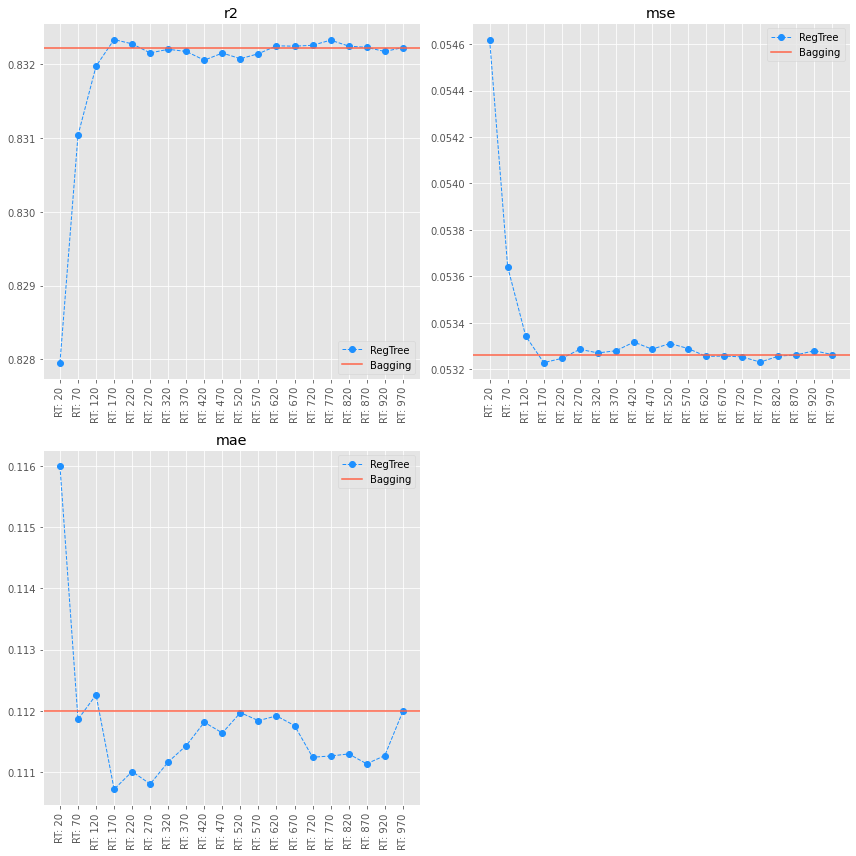

In [15]:
params = [[1, tmp_r2_test, r2_score(y_test, tmp_bag_model.predict(X_test)), 'r2'], 
            [2, tmp_mse_test, mean_squared_error(y_test, tmp_bag_model.predict(X_test)), 'mse'], 
            [3, tmp_mae_test, median_absolute_error(y_test, tmp_bag_model.predict(X_test)), 'mae']]

plt.figure(figsize = (12, 12))

for i in params:
    plt.subplot(2, 2, i[0])
    afx.plot_bagging_behavior(i[1], i[2], n_tree)
    plt.title(str(i[3]))
    plt.tight_layout()


#### Probando la correlación entre árboles
Los clasificadores débiles deben ser diversos, esto quiere decir que la correlación entre las
predicciones de dos árboles deben ser bajas. Implementando nuestro primer modelo con 10
estimadores, las correlaciones bivariadas entre los puntajes predichos de cada árbol son lo
suficientemente fuertes como para levantar sospechas. Esto es problemático dado que
nuestro modelo de ensamble estará siendo entrenado con información repetida. Para
evaluar la correlación entre cada uno de los árboles, generaremos las predicciones de cada
uno de los árboles y posteriormente las correlacionaremos.

Text(0.5, 1.0, 'Correlación bivariada entre árboles')

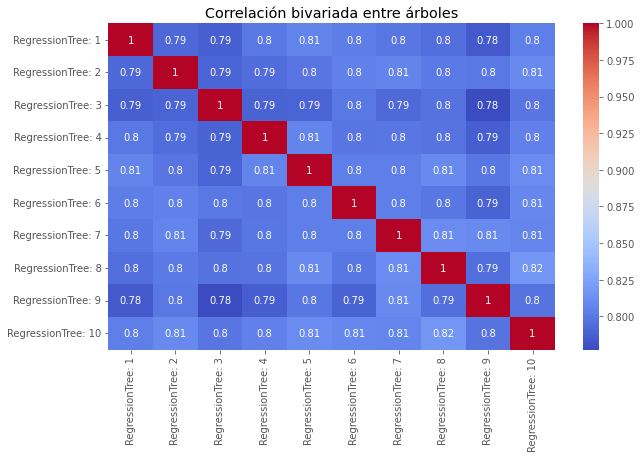

In [16]:
store_rho = []
"""
Guardamos los estimadores de nuestro
primer modelo.
"""
bag_est = bagging_model.estimators_
# recorremos dos veces los estimadores
for i in bag_est:
        for j in bag_est:
        # y calculamos las correlaciones entre pares
                store_rho.append(stats.pearsonr(i.predict(X_test), j.predict(X_test))[0])

store_rho = np.array(store_rho).reshape(len(bag_est), len(bag_est))
sns.heatmap(store_rho, cmap = 'coolwarm', annot = True, xticklabels = dec_tree_lab, yticklabels = dec_tree_lab)
plt.title('Correlación bivariada entre árboles')


El heatmap de arriba muestra evidencia a favor de la existencia de árboles correlacionados.
Esta es la principal piedra de tope de Bagging, y que da paso para hablar de su siguiente
iteración: Random Forest.